In [12]:
import pickle
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
from IPython.display import SVG
import matplotlib.pyplot as plt
%matplotlib inline
import os, re, sys, random, shutil, cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import applications, optimizers
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB7
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, ZeroPadding2D, Dropout

In [13]:
root_dir = '/kaggle/input/Semantic segmentation dataset'
images_dir = 'data/images'
masks_dir = 'data/masks'
os.makedirs(images_dir, exist_ok=True)
os.makedirs(masks_dir, exist_ok=True)

In [14]:
# # To delete the files in working folder to avoid repeated augmentation
# import shutil
# shutil.rmtree('/kaggle/working/')

In [15]:
tile_sizes = {
    '1': (512, 512),
    '2': (480, 480),
    '3': (512, 512),
    '4': (800, 800),
    '5': (1024, 1024),
    '6': (800, 800),
    '7': (1600, 1600),
    '8': (1920, 1280)
}

# Function to get files of images together and masks together of each and every tile
for tile in os.listdir(root_dir):
    if tile != 'classes.json':
        if tile[-1] in tile_sizes.keys():
            tile_dir = os.path.join(root_dir, tile)
            for tile_attribute in os.listdir(tile_dir):
                tile_attribute_dir = os.path.join(tile_dir, tile_attribute)
                dest_dir = images_dir if tile_attribute == 'images' else masks_dir
                for file in os.listdir(tile_attribute_dir):
                    old_dir = os.path.join(tile_attribute_dir, file)
                    new_dir = os.path.join(dest_dir, f'image_t{tile[-1]}{file[-8:]}') #to copy the dir formed without classes.json into new dir
#                     img = Image.open(old_dir)
#                     img = img.resize(tile_sizes[tile[-1]], Image.Resampling.LANCZOS)
#                     img = img.resize(tile_sizes[tile[-1]], Image.ANTIALIAS)
#                     img.save(new_dir)
                    shutil.copy(old_dir, new_dir)

images_files = [os.path.join(images_dir, file) for file in sorted(os.listdir(images_dir))]
masks_files = [os.path.join(masks_dir, file) for file in sorted(os.listdir(masks_dir))]
images_train, images_test, masks_train, masks_test = train_test_split(images_files, masks_files, test_size=0.22, random_state=42)



In [16]:
def augment(width, height):
    transform = A.Compose([
        A.RandomCrop(width=width, height=height, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.VerticalFlip(p=1.0),
        A.Rotate(limit=[60, 300], p=1.0, interpolation=cv2.INTER_NEAREST),
        A.RandomBrightnessContrast(brightness_limit=[-0.2, 0.3], contrast_limit=0.2, p=1.0),
        A.OneOf([
            A.CLAHE (clip_limit=1.5, tile_grid_size=(8, 8), p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, interpolation=cv2.INTER_NEAREST, p=0.5),
        ], p=1.0),
    ], p=1.0)

    return transform

'''
-->Albumentations is a Python library for fast and flexible image augmentations. Albumentations 
efficiently implements a rich variety of image transform operations that are optimized for 
performance, and does so while providing a concise, yet powerful image augmentation interface 
for different computer vision tasks, including object classification, segmentation, and
detection.
--> Augmentation is done or used to increase the number of images in the dataset

Data augmentation is done by the following techniques:

    Random Cropping
    Horizontal Flipping
    Vertical Flipping
    Rotation
    Random Brightness & Contrast
    Contrast Limited Adaptive Histogram Equalization (CLAHE)
    Grid Distortion
    Optical Distortion

'''

'\n-->Albumentations is a Python library for fast and flexible image augmentations. Albumentations \nefficiently implements a rich variety of image transform operations that are optimized for \nperformance, and does so while providing a concise, yet powerful image augmentation interface \nfor different computer vision tasks, including object classification, segmentation, and\ndetection.\n--> Augmentation is done or used to increase the number of images in the dataset\n\nData augmentation is done by the following techniques:\n\n    Random Cropping\n    Horizontal Flipping\n    Vertical Flipping\n    Rotation\n    Random Brightness & Contrast\n    Contrast Limited Adaptive Histogram Equalization (CLAHE)\n    Grid Distortion\n    Optical Distortion\n\n'

In [17]:
#images_train

In [18]:
aug_images_train = []
aug_masks_train = []
for i in range(8):
    for file in images_train:
        filename = file.split('/')[-1].split('.')[0]  #[-1]: Takes the last element of the list, which represents the filename with its extension
        tile = filename.split('_')[1][-1]
        img = cv2.imread(images_dir+'/'+filename+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(masks_dir+'/'+filename+'.png')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        transform = augment(tile_sizes[tile][0], tile_sizes[tile][1])  #[0] means images and [1] means masks
        transformed = transform(image=img, mask=mask)
        transformed_image = transformed['image']
        transformed_mask = transformed['mask']
        aug_images_train.append(images_dir + '/aug_{}_'.format(str(i+1))+filename+'.jpg')
        aug_masks_train.append(masks_dir + '/aug_{}_'.format(str(i+1))+filename+'.png')
        cv2.imwrite(images_dir + '/aug_{}_'.format(str(i+1))+filename+'.jpg',cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
        cv2.imwrite(masks_dir + '/aug_{}_'.format(str(i+1))+filename+'.png',cv2.cvtColor(transformed_mask, cv2.COLOR_BGR2RGB))
images_train = images_train + aug_images_train
masks_train = masks_train + aug_masks_train

train_images_dir = 'train_images/train'
train_masks_dir = 'train_masks/train'
test_images_dir = 'test_images/test'
test_masks_dir = 'test_masks/test'
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

for file in images_train:
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(images_dir + '/' + filename + '.jpg', train_images_dir + '/' + filename + '.jpg')
    shutil.copy(masks_dir + '/' + filename + '.png', train_masks_dir + '/' + filename + '.png')
for file in images_test:
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(images_dir + '/' + filename + '.jpg', test_images_dir + '/' + filename + '.jpg')
    shutil.copy(masks_dir + '/' + filename + '.png', test_masks_dir + '/' + filename + '.png')

# the below provided are colour codes which define different classes of images asin roads, buildings,etc..
# and these colour codes will already be given in dataset
class_dict_df = pd.DataFrame([(60, 16, 152),
                  (132, 41, 246),
                  (110, 193, 228),
                  (254, 221, 58),
                  (226, 169, 41),
                  (155, 155, 155)],
                ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled'])
class_dict_df.columns = ['r', 'g', 'b']

label_names= list(class_dict_df.index)
label_codes = []
r= np.asarray(class_dict_df.r)
g= np.asarray(class_dict_df.g)
b= np.asarray(class_dict_df.b)

for i in range(len(class_dict_df)):
    label_codes.append(tuple([r[i], g[i], b[i]]))

label_codes, label_names

code2id = {v:k for k,v in enumerate(label_codes)}
id2code = {k:v for k,v in enumerate(label_codes)}

name2id = {v:k for k,v in enumerate(label_names)}
id2name = {k:v for k,v in enumerate(label_names)}

In [19]:
def rgb_to_onehot(rgb_image, colormap = id2code):
    '''Function to one hot encode RGB mask labels
        Inputs: 
            rgb_image - image matrix (eg. 256 x 256 x 3 dimension numpy ndarray)
            colormap - dictionary of color to label id
        Output: One hot encoded image of dimensions (height x width x num_classes) where num_classes = len(colormap)
    '''
    num_classes = len(colormap)
    shape = rgb_image.shape[:2]+(num_classes,) #The trailing comma is added to ensure that it's interpreted as a tuple even when num_classes is just a single value.
    encoded_image = np.zeros( shape, dtype=np.int8 )
    for i, cls in enumerate(colormap):
        encoded_image[:,:,i] = np.all(rgb_image.reshape( (-1,3) ) == colormap[i], axis=1).reshape(shape[:2])
    #rgb_image.reshape(-1,3)--> 3 corresponds to the RGB channels and -1 is used to flatten the last dimension (3 RGB channels) into a single dimension.
    
    return encoded_image

def onehot_to_rgb(onehot, colormap = id2code):
    '''Function to decode encoded mask labels
        Inputs: 
            onehot - one hot encoded image matrix (height x width x num_classes)
            colormap - dictionary of color to label id
        Output: Decoded RGB image (height x width x 3) 
    '''
    single_layer = np.argmax(onehot, axis=-1)
    #argmax:-converts the one-hot encoding back to a single-layer image where each pixel is represented by the class with the highest probability.
    output = np.zeros( onehot.shape[:2]+(3,) ) # converting 2D array into 3D back again  
    for k in colormap.keys():
        output[single_layer==k] = colormap[k]
    return np.uint8(output)

**CREATING DATA GENERATORS**


#Generators work in batches and hence save the RAM memory. For eg: If there are 16 images, generator will make batches of 4. It will work on the first 4 images and then remove those to work on the next 4. Generator makes a tuple consisting of the images , classes

In [20]:
# Normalizing only frame images, since masks contain label info
data_gen_args = dict(rescale=1./255)
mask_gen_args = dict()

train_frames_datagen = ImageDataGenerator(**data_gen_args)
train_masks_datagen = ImageDataGenerator(**mask_gen_args)
val_frames_datagen = ImageDataGenerator(**data_gen_args)
val_masks_datagen = ImageDataGenerator(**mask_gen_args)

# Seed defined for aligning images and their masks
seed = 1

**CUSTOMIZE THE DATA GENERATOR BASED ON OUR DATA**


In [21]:
# FOR TRAINING 

def TrainAugmentGenerator(train_images_dir, train_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Train Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            train_images_dir - train images directory
            train_masks_dir - train masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    train_image_generator = train_frames_datagen.flow_from_directory(
    train_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    train_mask_generator = train_masks_datagen.flow_from_directory(
    train_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)

    while True:
        X1i = train_image_generator.next()  # once one batch is completed, it will go to next batch
        X2i = train_mask_generator.next()
        
        #print(X2i[0].shape, X2i[1].shape)
        #print(X2i[0],X1i[1])
        #print(X2i[0][1,:,:,:].shape)
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        # X2i[0][x,:,:,:]--> X2i[0] means first element of tuple X2i which consists of all the images
        #                --> [x,:,:,:] means xth image of particular batch
        #X2i[0].shape[0] --> means first element of tuple which is (8,512,512,3) and shape[0] means 8 i.e. batch_Size
        
        yield X1i[0], np.asarray(mask_encoded)

# FOR TESTING 
def ValAugmentGenerator(val_images_dir, val_masks_dir, seed = 1, batch_size = 8, target_size = (512, 512)):
    '''Validation Image data generator
        Inputs: 
            seed - seed provided to the flow_from_directory function to ensure aligned data flow
            batch_size - number of images to import at a time
            val_images_dir - validation images directory
            val_masks_dir - validation masks directory
            target_size - tuple of integers (height, width)
            
        Output: Decoded RGB image (height x width x 3) 
    '''
    val_image_generator = val_frames_datagen.flow_from_directory(
    val_images_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    val_mask_generator = val_masks_datagen.flow_from_directory(
    val_masks_dir,
    batch_size = batch_size, 
    seed = seed, 
    target_size = target_size)


    while True:
        X1i = val_image_generator.next()
        X2i = val_mask_generator.next()
        
        #One hot encoding RGB images
        mask_encoded = [rgb_to_onehot(X2i[0][x,:,:,:], id2code) for x in range(X2i[0].shape[0])]
        
        yield X1i[0], np.asarray(mask_encoded)

In [14]:
#next(TrainAugmentGenerator('train_images', 'train_masks', seed = 1, batch_size = 8, target_size = (512, 512)))

In [15]:
#next(TrainAugmentGenerator('test_images', 'test_masks', seed = 1, batch_size = 8, target_size = (512, 512)))

**MODEL**

In [22]:
batch_size = 8
num_train_samples = len(np.sort(os.listdir('/kaggle/working/train_images/train')))
num_val_samples = len(np.sort(os.listdir('/kaggle/working/test_images/test')))
steps_per_epoch = np.ceil(float(num_train_samples) / float(batch_size))
print('steps_per_epoch: ', steps_per_epoch)
validation_steps = np.ceil(float(4 * num_val_samples) / float(batch_size))
print('validation_steps: ', validation_steps)

steps_per_epoch:  63.0
validation_steps:  8.0


## InceptionResNetV2-UNet

In [23]:
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import ZeroPadding2D

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    # include_top: whether to include the fully-connected layer at the top of the network.
    # weights: one of None (random initialization), "imagenet" (pre-training on ImageNet), or the path to the weights file to be loaded.
    # input_tensor: optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model.
    
    """ Encoder """
    s1 = encoder.get_layer("input_1").output           ## (512 x 512)

    s2 = encoder.get_layer("activation").output        ## (255 x 255)
    s2 = ZeroPadding2D(( (1, 0), (1, 0) ))(s2)         ## (256 x 256)

    '''
    For s2:
(1, 0) in the first tuple: It means padding of 1 unit on the top and 0 units on the bottom for the first dimension.
(1, 0) in the second tuple: It means padding of 1 unit on the left and 0 units on the right for the second dimension.
So, the total padding applied is (1 unit on top, 0 units on bottom) and (1 unit on left, 0 units on right), resulting in an output size of (256 x 256).

    For s3:
(1, 1): It means padding of 1 unit on both sides (left and right) for both dimensions.
    '''
    s3 = encoder.get_layer("activation_3").output      ## (126 x 126)
    s3 = ZeroPadding2D((1, 1))(s3)                     ## (128 x 128)

    s4 = encoder.get_layer("activation_74").output      ## (61 x 61)
    s4 = ZeroPadding2D(( (2, 1),(2, 1) ))(s4)           ## (64 x 64)

    """ Bridge """
    b1 = encoder.get_layer("activation_161").output     ## (30 x 30)
    b1 = ZeroPadding2D((1, 1))(b1)                      ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    dropout = Dropout(0.3)(d4)
    outputs = Conv2D(6, 1, padding="same", activation="softmax")(dropout)

    #dropout is a regularization technique that helps prevent overfitting by 
    #randomly setting a fraction of input units to zero during training. This introduces noise during training and helps the model generalize better to unseen data.
   
    model = Model(inputs, outputs, name="InceptionResNetV2-UNet")
    return model

In [24]:
from tensorflow.keras import backend as K


K.clear_session()

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

model = build_inception_resnetv2_unet(input_shape = (512, 512, 3))
model.compile(optimizer=Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=[dice_coef, "accuracy"])
#model.summary()

'''
->adam optmizer: function that adapts the neural network's attributes, like learning rate and weights.
->used to measure the similarity between two sets.

->Dice similarity coefficient, returned as a numeric scalar or numeric vector 
with values in the range [0, 1]. A similarity of 1 means that the segmentations 
in the two images are a perfect match i.e one image is exactly above another image .

'''

219055592/219055592 [==============================] - 1s 0us/step


"\n->adam optmizer: function that adapts the neural network's attributes, like learning rate and weights.\n->used to measure the similarity between two sets.\n\n->Dice similarity coefficient, returned as a numeric scalar or numeric vector \nwith values in the range [0, 1]. A similarity of 1 means that the segmentations \nin the two images are a perfect match i.e one image is exactly above another image .\n\n"

In [25]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.0001, 60)

lr_scheduler = LearningRateScheduler(
    exponential_decay_fn,
    verbose=1
)

# LearningRateScheduler:- decreases learning rate at every epoch 
checkpoint = ModelCheckpoint(
    filepath = 'InceptionResNetV2-UNet.h5',
    save_best_only = True, 
#     save_weights_only = False,
    monitor = 'val_loss', 
    mode = 'auto', 
    verbose = 1
)

earlystop = EarlyStopping(
    monitor = 'val_loss', 
    min_delta = 0.001, 
    patience = 12, 
    mode = 'auto', 
    verbose = 1,
    restore_best_weights = True
)

csvlogger = CSVLogger(
    filename= "model_training.csv",
    separator = ",",
    append = False
)

callbacks = [checkpoint, earlystop, csvlogger, lr_scheduler]

In [26]:
history = model.fit(
    TrainAugmentGenerator(train_images_dir = '/kaggle/working/train_images', train_masks_dir = '/kaggle/working/train_masks', target_size = (512, 512)), 
    steps_per_epoch=steps_per_epoch,
    validation_data = ValAugmentGenerator(val_images_dir = '/kaggle/working/test_images', val_masks_dir = '/kaggle/working/test_masks', target_size = (512, 512)), 
    validation_steps = validation_steps, 
    epochs = 50,
    callbacks=callbacks,
    use_multiprocessing=False,
    verbose=1
)

Found 504 images belonging to 1 classes.
Found 504 images belonging to 1 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/50


2024-01-30 05:31:49.694857: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inInceptionResNetV2-UNet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1706592741.373166     157 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - ETA: 0s - loss: 1.2964 - dice_coef: 0.3717 - accuracy: 0.5828Found 16 images belonging to 1 classes.
Found 16 images belonging to 1 classes.

Epoch 1: val_loss improved from inf to 1.57572, saving model to InceptionResNetV2-UNet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 288s 2s/step - loss: 1.2964 - dice_coef: 0.3717 - accuracy: 0.5828 - val_loss: 1.5757 - val_dice_coef: 0.2116 - val_accuracy: 0.6307 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.623506263980886e-05.
Epoch 2/50
63/63 [==============================] - ETA: 0s - loss: 0.8491 - dice_coef: 0.5565 - accuracy: 0.7519
Epoch 2: val_loss improved from 1.57572 to 1.15267, saving model to InceptionResNetV2-UNet.h5
63/63 [==============================] - 144s 2s/step - loss: 0.8491 - dice_coef: 0.5565 - accuracy: 0.7519 - val_loss: 1.1527 - val_dice_coef: 0.3487 - val_accuracy: 0.7535 - lr: 9.6235e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.261187281287936e-05.
Epoch 3/50
63/63 [==============================] - ETA: 0s - loss: 0.6792 - dice_coef: 0.6354 - accuracy: 0.8014
Epoch 3: val_loss improved from 1.15267 to 0.80495, saving model to InceptionResNetV2-UNet.h5
63/63 [==============================] - 1

In [27]:
img_path = "/kaggle/working/test_images/test/image_t1_006.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (512,512)) / 255.0
img = np.expand_dims(img, axis = 0)  # since we are playing with batches , to extract just 1 batch we use axis=0
mask = onehot_to_rgb(model.predict(img)[0], id2code)

1/1 [==============================] - 9s 9s/step


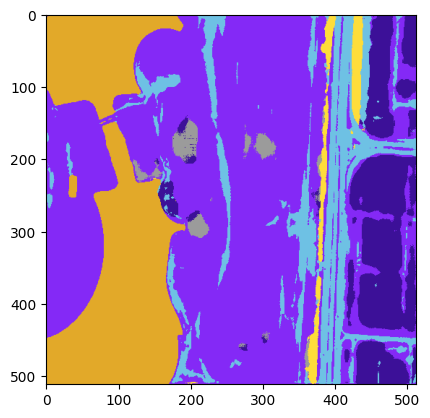

In [28]:
plt.imshow(mask)

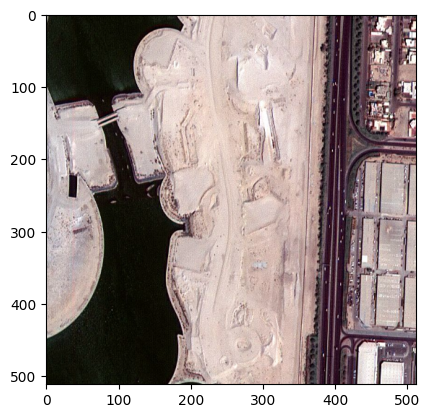

In [29]:
plt.imshow(img[0])